In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
from simtk import unit
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app

# El potencial de doble pozo

Nota: Explicar que en el caso de la interacción entre dos partículas, que se asociacion y se disocian, el modelo físico más sencillo es el potencial de tipo doble pozo.

## El potencial de doble pozo unidimensional en $X$

Un potencial de doble pozo, en una dimensión, puede encontrarse descrito por la siguiente expresión:

\begin{equation}
V(x)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x
\end{equation}

Veamos el significado de las constantes $E_{0}$, $a$ and $b$. Con este propósito el siguiente método no servirá de utilidad para evaluar la contribución al potencial de los distintos términos que construyen el doble pozo en $X$.

In [2]:
def double_well_potential_1D(x,Eo,a,b):
    return Eo*((x/a)**4-2*(x/a)**2)-(b/a)*x

### Caso simétrico ($b=0$)

El caso de un potencial de doble pozo simétrico puede ser encontrado de la expresión matemática anterior cuando $b=0$:

\begin{equation}
V(x)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]
\end{equation}

En esta situación, los mínimos del doble pozo se localizan en $x=-a$ y $x=a$. Y el valor de $E_{0}$ no es otra cosa que la altura de la barrera (desde cualquiera de los dos mínimos). Veamos esto con un ejemplo:

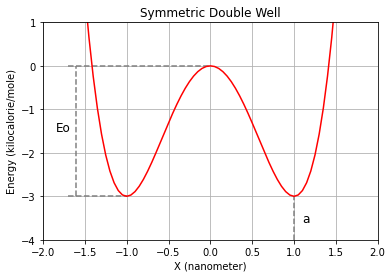

In [3]:
Eo=3.0 * unit.kilocalories_per_mole # Altura de la barrera para el caso simétrico.
a=1.0 * unit.nanometers # Valor absoluto de las coordenadas de los mínimos.
b=0.0 * unit.kilocalories_per_mole # No necesita explicación en este momento.

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers

plt.plot(x_serie, double_well_potential_1D(x_serie,Eo,a,b), 'r-')
plt.ylim(-4,1)
plt.xlim(-2,2)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Symmetric Double Well")

plt.hlines(-3, -1.7, -1, color='gray', linestyle='--')
plt.hlines(0, -1.7, 0, color='gray', linestyle='--')
plt.vlines(-1.6, -3, 0, color='gray', linestyle='--')
plt.vlines(1, -4, -3, color='gray', linestyle='--')
plt.text(-1.85, -1.5, 'Eo', fontsize=12)
plt.text(1.1, -3.6, 'a', fontsize=12)

plt.show()

Podemos también corroborar esto analíticamente. Calculemos la posición de los mínimos y del máximo. Sabemos que en estos tres puntos cumplen que la derivada primera del potencial es igual a cero.

In [4]:
x, Eo, a = sy.symbols('x Eo a')
f = Eo*((x/a)**4-2*(x/a)**2)

g=sy.diff(f,x) # Primera derivada con respecto a x de la funcion f

In [5]:
print('Primera derivada del potencial:')
g

Primera derivada del potencial:


Eo*(-4*x/a**2 + 4*x**3/a**4)

La primera derivada puede ser factorizada para descubrir el valor de las tres raices (valores de x que hacen cero a una función): $x=0$ como la posición de la barrera y $x=a$ y $x=-a$ como la posición de los mínimos:

In [6]:
sy.factor(g)

4*Eo*x*(-a + x)*(a + x)/a**4

La altura de la barrera, desde la posición de los mínimos, puede ser calculada como:

\begin{equation}
V(0)-V(a)=0-E_{0}\left[ 1-2 \right]=E_{0}
\end{equation}

#### La frecuencia de las pequeñas oscilaciones alrededor de los mínimos

Ahora que ya conocemos el rol de $E_{0}$ y $a$ en el potencial de doble pozo simétrico, vamos a ver qué podemos decir de las pequeñas oscilaciones alrededor de un mínimo de energía. El periodo de estas oscilaciones nos servirá de referencia para elegir el paso de tiempo de integración adecuado a la hora de simular la dinámica de una partícula en este potencial. Tenemos que trabajar con la segunda derivada del potencial para aproximar el potencial a una función armónica en $x=a$.

El valor de cualquier función matemática puede ser aproximado alrededor de un mínimo mediante el valor de la función en ese punto mas la contribución armónica en su entorno. Esta contribución corresponde a la curvatura calculada como el valor de la segunda derivada de la función en el punto de estudio -en este caso el mínimo-. Es lo que se conoce como la expansión de Taylor de una función (truncada aquí en el tercer grado):

\begin{equation}
f(x) \approx f(x_{0}) + f'(x_{0})(x-x_{0}) + \frac{1}{2} f''(x_{0})(x-x_{0})^{2}
\end{equation}

Y por definición de mínimo para $x_{0}$:

\begin{equation}
f'(x_{0})=0
\end{equation}

Así que:

\begin{equation}
f(x) \approx f(x_{0}) + \frac{1}{2} f''(x_{0})(x-x_{0})^{2}
\end{equation}

En este punto hagamos un paréntesis. Todos sabemos que la ley de Hooke describe la fuerza sufrida por una masa unida al extremo de un muelle ideal alrededor de su posición de equilibrio:

\begin{equation}
F(x) = -k(x-x_{0})
\end{equation}

Donde $k$ es la constante elástica o rigidez del muelle y $x_{0}$ su posición de equilibrio. El potencial $V(x)$ que da lugar entonces a esta fuerza cumple, en el caso de una dimensión, con la siguiente expresión:

\begin{equation}
F(x) = -\frac{d V(x)}{dx}
\end{equation}

Así que la fuerza del resorte es el resultado de un potencial armónico:

\begin{equation}
V(x) = \frac{1}{2} k (x-x_{0})^{2}
\end{equation}

Y la frecuencia de oscilación de la partícula se puede calcular como:

\begin{equation}
\omega = \sqrt{\frac{k}{m}}
\end{equation}

Donde $m$ es la masa de la partícula. Así que el potencial armónico también puede ser escrito como:

\begin{equation}
V(x) = \frac{1}{2} k (x-x_{0})^{2} = \frac{1}{2} m \omega^{2} (x-x_{0})^{2}
\end{equation}

Ahora, volviendo a nuestra expanxión de Taylor de una función matemática cualquiera $f(x)$. Si la forma de la función entorno al mínimo $x_{0}$ puede ser aproximada por una función armónica, esto quiere decir que la frecuencia angular característica $\omega$ de las oscilaciones en el fondo del mínimo es, por comparación con el potencial detrás de la ley de Hooke:

\begin{equation}
\omega = \sqrt{\frac{f''(x_{0})}{m}}
\end{equation}

De esta manera, la frecuecia de las pequeñas oscilaciones de una partícula de masa $m$ alrededor del mínimo de nuestro potencial de doble pozo simétrico puede ser obtenido de la segunda derivada del potencial en dicho mínimo:

In [7]:
x, Eo, a = sy.symbols('x Eo a')
f = Eo*((x/a)**4-2*(x/a)**2)

gg=sy.diff(f,x,x) # Second derivative of f with respect x

gg

-4*Eo*(1 - 3*x**2/a**2)/a**2

Veamos el valor de esta expresión cuando $x=a$:

In [8]:
gg.subs({x:a})

8*Eo/a**2

Así que la frecuencia angular de las oscilaciones es:

\begin{equation}
\omega = \sqrt{\frac{8E_{0}}{ma^{2}}}
\end{equation}

Y el periodo:

\begin{equation}
T = \frac{2\pi}{\omega} = 2\pi \sqrt{\frac{ma^{2}}{8E_{0}}}
\end{equation}

Podemos ver gráficamente cuan buena o mala es esta aproximación en las proximidades del mínimo:

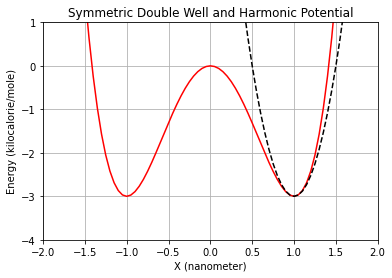

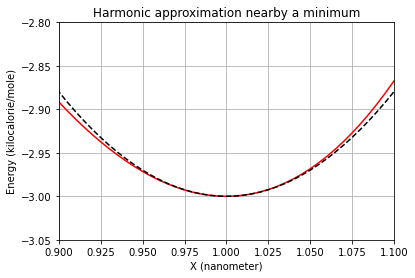

In [9]:
def harmonic_well_potential_1D(x,k,a,Eo):
    return 0.5*k*(x-a)**2-Eo

Eo=3.0 * unit.kilocalories_per_mole # barrier height when the double well is symmetric.
a=1.0 * unit.nanometers # Absolute value of the coordinates of minima (the potential is an even function).
b=0.0 * unit.kilocalories_per_mole # No need to explanation at this moment
k=(8*Eo)/a**2 # harmonic stiffness

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers

plt.plot(x_serie, double_well_potential_1D(x_serie,Eo,a,b), 'r-')
plt.plot(x_serie, harmonic_well_potential_1D(x_serie,k,a,Eo), color='k', linestyle='--')
plt.ylim(-4,1)
plt.xlim(-2,2)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Symmetric Double Well and Harmonic Potential")
plt.show()

x_serie = np.arange(-0.5, 1.5, 0.005) * unit.nanometers

plt.plot(x_serie, double_well_potential_1D(x_serie,Eo,a,b), 'r-')
plt.plot(x_serie, harmonic_well_potential_1D(x_serie,k,a,Eo), color='k', linestyle='--')
plt.ylim(-3.05,-2.8)
plt.xlim(0.9,1.1)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Harmonic approximation nearby a minimum")
plt.show()

### Caso asimétrico ($b\neq0$)

En el caso de que $b\neq 0$, nuestro double pozo se vuelve asimétrico. En esta situación $E_{0}$ y $a$ tienen **aproximadamente** la misma interpretación, y $b$ puede ser entendido **aproximadamente** como la cantidad de energía que un pozo sube o baja, dependiendo de su posición relativa con respecto a $x=0$. En nuestro caso, el pozo izquierdo se eleva y el derecho se hunde cuando $b>0$. Veamos esto en una representación gráfica:

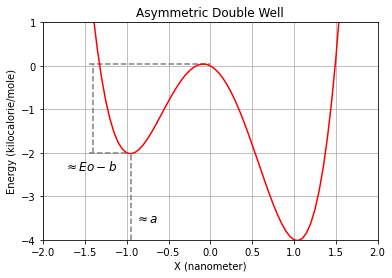

In [10]:
Eo=3.0 * unit.kilocalories_per_mole # Altura de la barrera para el caso simétrico.
a=1.0 * unit.nanometers # Valor absoluto de las coordenadas de los mínimos.
b=1.0 * unit.kilocalories_per_mole # Desplazamiento vertical de las cuencas (aproximadamente).

x_serie = np.arange(-5., 5., 0.05) * unit.nanometers

plt.plot(x_serie, double_well_potential_1D(x_serie,Eo,a,b), 'r-')
plt.ylim(-4,1)
plt.xlim(-2,2)
plt.grid()
plt.xlabel("X ({})".format(unit.nanometers))
plt.ylabel("Energy ({})".format(unit.kilocalories_per_mole))
plt.title("Asymmetric Double Well")

plt.hlines(-2, -1.45, -1, color='gray', linestyle='--')
plt.hlines(0.05, -1.45, 0, color='gray', linestyle='--')
plt.vlines(-1.4, -2, 0.05, color='gray', linestyle='--')
plt.vlines(-0.95, -4, -2, color='gray', linestyle='--')
plt.text(-1.75, -2.4, r'$\approx Eo-b$', fontsize=12)
plt.text(-0.9, -3.6, r'$\approx a$', fontsize=12)

plt.show()

El valor de la energía de la barrera es desde el pozo izquierdo es **aproximadamente** $E_{0}-b$ y **aproximadamente** $E_{0}+b$ desde el pozo derecho.

#### Frecuencia de las pequeñas oscilaciones alrededor de los mínimos

Dado que $b$ está incluido en la expresión del potencial en el término lineal, su efecto desaparece en la segunda derivada. Pero debemos recalcular el valor exacto de los mínimos para obtener los nuevos valores de los periodos de oscilación entorno al fondo de las dos cuencas de atracción.

## Un potencial armónico en $Y$ y $Z$

Para simular la partícula en tres dimensiones y que ésta no difunda al infinito, podemos añadir un potencial armónico en $Y$ y $Z$. Estudiar el doble pozo unidimensional y el comportamiento en el eje $X$ del siguiente potencial tridimensional, es totalmente equivalente:

\begin{equation}
V(x,y,z)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x + \frac{1}{2}k\left( y^2 + z^2 \right)
\end{equation}

Al adjudicar el valor de la constante elástica para $Y$ y $Z$ debemos asegurarnos de que es tal que no habrá problemas de integración en estos ejes para que la energía total y el momento se conserve. Podríamos por ejemplo hacer, con la siguiente elección, que la escala temporal de las oscilaciones en estos ejes sea similar o mayor a las pequeñas oscilaciones en $X$. Para que la limitante a la hora de elegir el paso de integración sean las curvaturas de los mínimos del doble pozo, y no los potenciales auxiliares armónicos de $Y$ y $Z$ en cuyo subespacio el comportamiento de la partícula no nos interesa mucho ahora mismo.

\begin{equation}
k \le \frac{8E_{0}}{a^{2}}
\end{equation}

## Simulación de la dinámica del sistema

Simularemos la dinámica de una partícula en un potencial de doble pozo asimétrico en tres circunstancias distintas pero con el mismo protocolo: el sistema aislado -dinámica newtoniana-, el sistema en contacto con un medio disipativo -dinámica newtoniana amortiguada-, y el sistema en contacto con un baño térmico -dinámica estocástica-. Y lo haremos con la misma herramienta, estudiando la dinámica de Langevin. Primero a temperatura y amortiguamiento cero, a temperatura cero con amortiguamiento distinto de cero, y a temperatura y amortiguamiento distintos de cero.

En primer lugar definamos el sistema para hacer la simulación con OpenMM.

In [11]:
# Definición del sistema.

n_particles = 1
mass = 35.453 * unit.amu # masa del átomo Cl

# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)
    
# Añadimos el potencial de doble pozo

k = 1.0 * unit.kilocalories_per_mole/unit.angstrom**2
Eo = 3.0 * unit.kilocalories_per_mole
a = 5 * unit.angstrom
b = 0.5 * unit.kilocalories_per_mole

A = Eo/a**4     # Reescribimos las constantes del potencial para que sea más eficiente
B = -2*Eo/a**2
C = -b/a
D = 0.5*k

force = mm.CustomExternalForce('A*x^4+B*x^2+C*x + D*y^2+ D*z^2')
force.addGlobalParameter('A', A)
force.addGlobalParameter('B', B)
force.addGlobalParameter('C', C)
force.addGlobalParameter('D', D)

for ii in range(n_particles):
    force.addParticle(ii, [])

_ = system.addForce(force)

En todas las situaciones integraremos la dinámica con un paso de integración al menos 10 veces menor que el periodo de las oscilaciones armónicas más rápidas del sistema. Con esta elección de parametros sabemos que para las pequeñas oscilaciones en el doble pozo si las unidades de los parámetros son amus, angstroms y kilocalorias/mol:

In [12]:
x, Eo, a, b = sy.symbols('x Eo a b')
f = Eo*((x/a)**4-2*(x/a)**2)-(b/a)*x 
f = f.subs({Eo:3, a:5, b:0.5})

g=sy.diff(f,x) # Primera derivada
roots=sy.solve(g,x) # Raices de la primera derivada: 2 minimos y 1 máximo
gg=sy.diff(f,x,x) # Segunda derivada

for root in roots:
    real_root = root.as_real_imag()[0] #La parte imaginaria es cero
    k = gg.subs({x:real_root})
    if k>0: # Sólo nos interesan los mínimos
        k = k * unit.kilocalories_per_mole/unit.angstrom**2
        T = 2 * np.pi * np.sqrt(mass/k)
        print('El periodo de oscilación del mínimo en {} es {}'.format(real_root*unit.angstroms, T))

El periodo de oscilación del mínimo en -4.89238389184391 A es 1.9293363155822159 ps
El periodo de oscilación del mínimo en 5.10108081198013 A es 1.812022971462434 ps


Y en los ejes $Y$ y $Z$:

In [13]:
k = 1.0 * unit.kilocalories_per_mole/unit.angstrom**2
T = 2 * np.pi * np.sqrt(mass/k)
print('El periodo de oscilación en Y y Z es {}'.format(T))

El periodo de oscilación en Y y Z es 1.8289866089177864 ps


Así que para integrar numéricamente las ecuaciones dinámicas sin problema, y para que las simulaciones sean lo suficientemente ilustrativas pero eficienes (sin elegir un paso de integración extremadamente pequeño):

In [14]:
step_size = 0.05 * unit.picoseconds

### Dinámica newtoniana

In [15]:
# Parámetros de la simulación de la dinámica de Langevin.

temperature = 0.0*unit.kelvin
friction = 0.0/unit.picosecond

simulation_time = 10.0*unit.picoseconds
saving_time = 0.05*unit.picoseconds

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.angstroms
initial_positions[0,0] = 6.0 * unit.angstroms

initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

# Definición del integrador

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

# Creación del contexto inicial.

context = mm.Context(system, integrator, platform)

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

# Parámetros auxiliares de la simulación.

n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 199/199 [00:00<00:00, 1523.20it/s]


Veamos ahora la trayectoria de la partícula en el espacio:

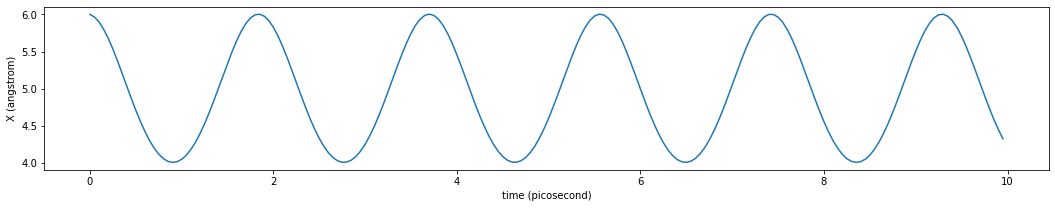

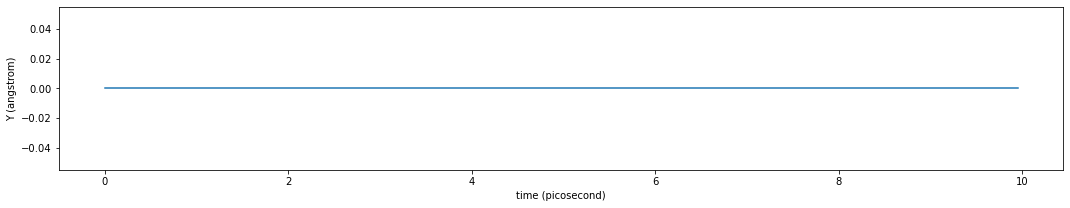

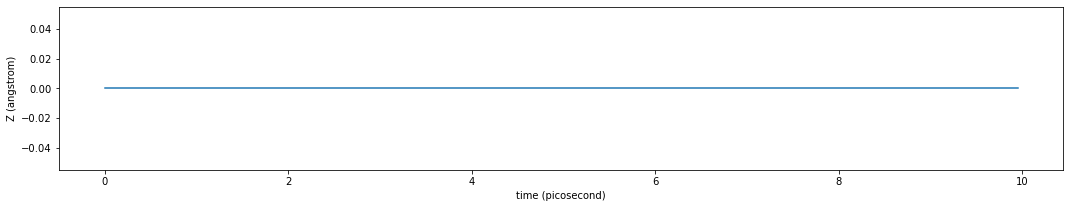

In [16]:
plt.rcParams['figure.figsize'] = 18, 3

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

El sistema está oscilando entorno a un mínimo. Veamos las energías en función del tiempo:

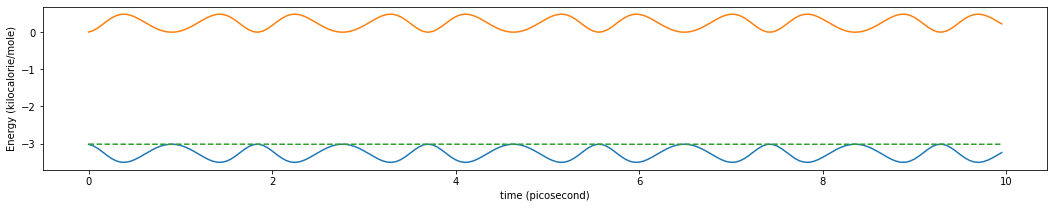

In [17]:
total_energies = potential_energies+kinetic_energies
plt.plot(times, potential_energies)
plt.plot(times, kinetic_energies)
plt.plot(times, total_energies, '--')
plt.ylabel('Energy ({})'.format(total_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()

### Dinámica newtoniana amortiguada

Para poder facilitar la realización de estos experimentos, hemos empaquetado el código de la creación de este sistema y su simulación con OpenMM en una librería de Python llamada OpenMolecularSystems. Así que, para no replicar tantas lineas de código, veamos como podemos realizar la simulación de este mismo sistema sin temperatura pero esta vez con amortiguamiento distinto de cero.  

In [33]:
import openmolecularsystems as oms

In [34]:
osystem = oms.DoubleWell(mass=35.453*unit.amu, Eo=3.0*unit.kilocalories_per_mole,
                         a=5*unit.angstrom, b=0.5*unit.kilocalories_per_mole,
                         k=1.0*unit.kilocalories_per_mole/unit.angstrom**2)

In [35]:
reporter = oms.tools.md.langevin_NVT(osystem, time=10*unit.picoseconds,
                                     saving_timestep=0.05*unit.picoseconds,
                                     integration_timestep=0.05*unit.picoseconds,
                                     temperature=0.0*unit.kelvin,
                                     friction=1.0/unit.picoseconds,
                                     initial_coordinates=initial_positions,
                                     initial_velocities=initial_velocities,
                                     platform_name='CUDA')

200it [00:00, 1951.08it/s]             


In [36]:
reporter.keys()

dict_keys(['time', 'coordinates', 'potential_energy', 'kinetic_energy', 'box'])

Veamos la trayectoria de la partícula en el espacio:

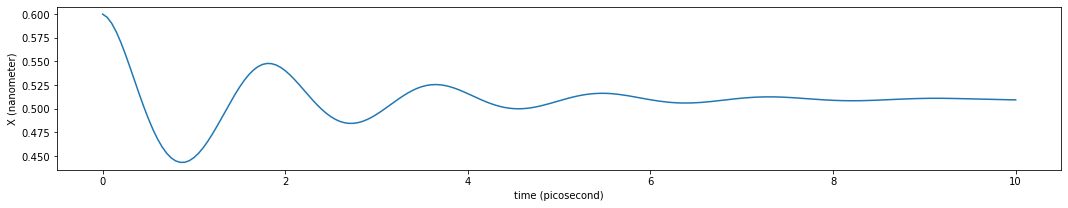

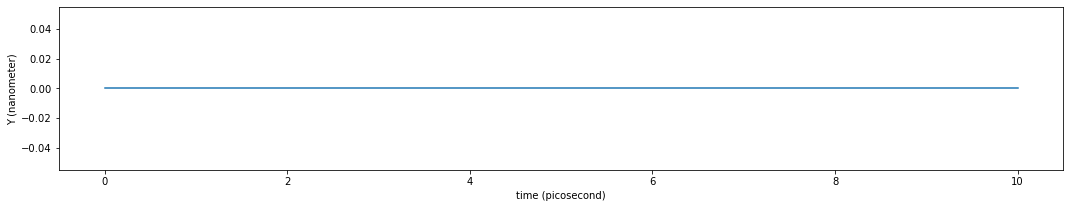

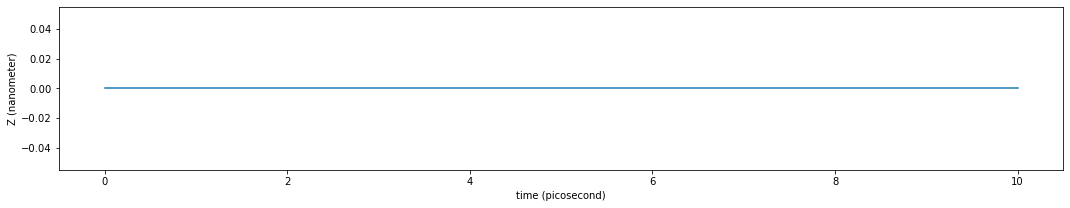

In [37]:
for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(reporter['time'], reporter['coordinates'][:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, reporter['coordinates'].unit))
    plt.xlabel('time ({})'.format(reporter['time'].unit))
    plt.show()

El sistema está oscilando brevemente entorno a un mínimo hasta que cae en él. La energía inicial acabó disipada:

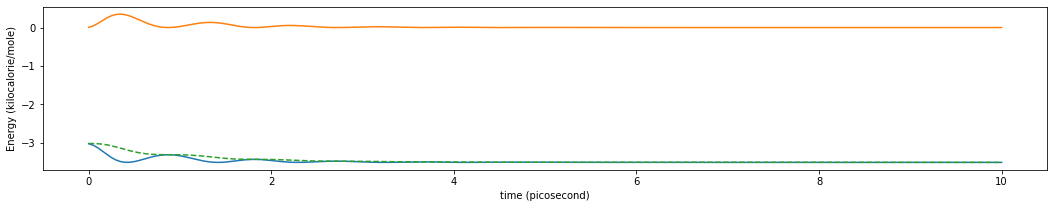

In [38]:
total_energies = reporter['potential_energy']+reporter['kinetic_energy']
plt.plot(reporter['time'], reporter['potential_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'], reporter['kinetic_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'], total_energies.in_units_of(unit.kilocalories_per_mole), '--')
plt.ylabel('Energy ({})'.format(unit.kilocalories_per_mole))
plt.xlabel('time ({})'.format(reporter['time'].unit))
plt.show()

### Dinámica estocástica

In [41]:
reporter = oms.tools.md.langevin_NVT(osystem, time=10*unit.picoseconds,
                                     saving_timestep=0.05*unit.picoseconds,
                                     integration_timestep=0.05*unit.picoseconds,
                                     temperature=300.0*unit.kelvin,
                                     friction=1.0/unit.picoseconds,
                                     initial_coordinates=initial_positions,
                                     initial_velocities=initial_velocities,
                                     platform_name='CUDA')

200it [00:00, 1814.97it/s]             


Veamos la trayectoria de la partícula en el espacio:

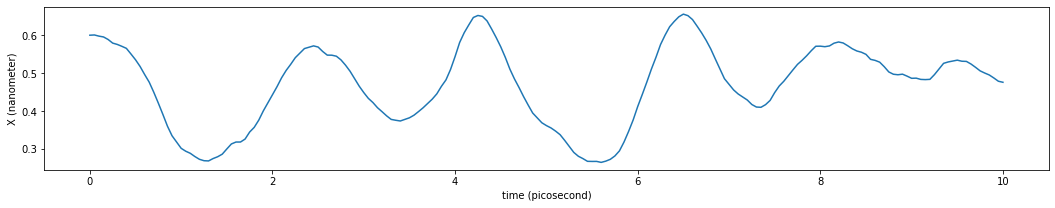

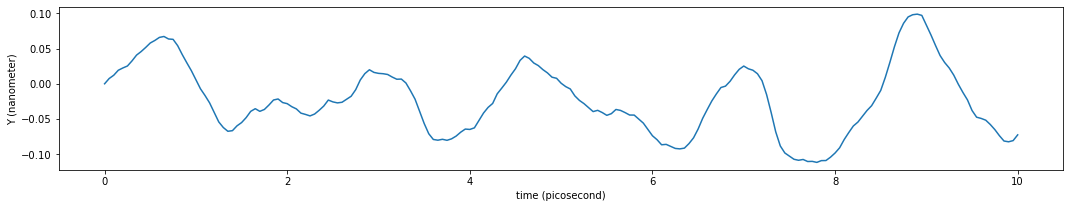

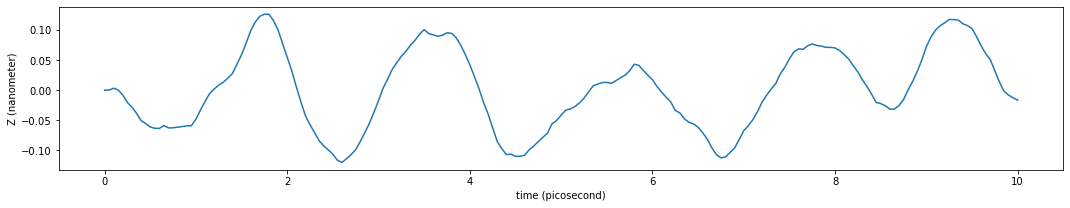

In [42]:
for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(reporter['time'], reporter['coordinates'][:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, reporter['coordinates'].unit))
    plt.xlabel('time ({})'.format(reporter['time'].unit))
    plt.show()

Como vemos podemos la partícula, al estar en contacto con un baño térmico que le aporta energía a través del término de fluctuación de la ecuación de Langevin, no termina cayendo a la posición del mínimo. Es más, los dos grados de libertad $Y$ y $Z$ en poco tiempo ganan energía y el movimiento en esos ejes se activa mostrando un comportamiento similar al observado en el eje $X$ -ya que las curvaturas del pozo son muy similares en las tres dimensiones-. Vemos también que la dinámica parece más lenta comparada con las oscilaciones en ausencia de amortiguamiento y temperatura. Veamos que sucede con las energías:

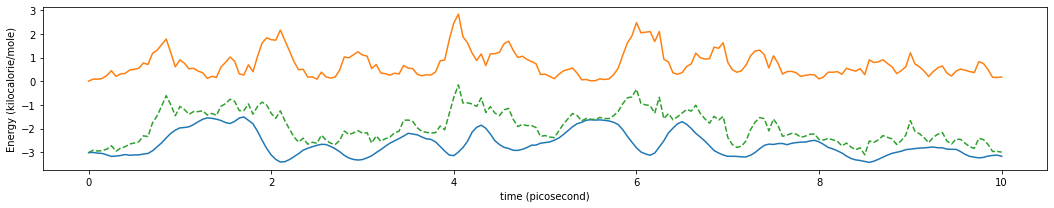

In [43]:
total_energies = reporter['potential_energy']+reporter['kinetic_energy']
plt.plot(reporter['time'], reporter['potential_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'], reporter['kinetic_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'], total_energies.in_units_of(unit.kilocalories_per_mole), '--')
plt.ylabel('Energy ({})'.format(unit.kilocalories_per_mole))
plt.xlabel('time ({})'.format(reporter['time'].unit))
plt.show()

No es perfectamente constante y fluctua. Es lo que esperábamos. Si bien, tenemos que ver en una trayectoria más larga como sus valores promedio acaban convergiendo.

## Las escalas de tiempo del doble pozo

La partícula en el doble pozo sufre unos procesos dinámicos con tres tiempos característicos. Por un lado tenemos el tiempo de relación de la partícula en cada uno de los mínimos, que en nuestro caso son de escala muy comparable. Y por otro lado tenemos el tiempo de relajación dado por la barrera. Si no estás todavía familiarizado con el concepto "tiempo de relajación" podemos verlo de otra manera. La dinámica de la particula en cada una de las dos cuencas de atracción es mucho más rápida que la dinámica entre cuencas (de salto de la barrera). De hecho, dada la temperatura y la altura de la barrera, el tiempo simulado en las secciones anteriores parece muy poco para observar si quiera un salto. Apuremos un poco el paso de integración para poder alcanzar tiempos mayores sin mucho esfuerzo computacional, y simulemos in periodo más largo de tiempo:

In [47]:
reporter = oms.tools.md.langevin_NVT(osystem, time=10*unit.nanoseconds,
                                     saving_timestep=10.0*unit.picoseconds,
                                     integration_timestep=0.1*unit.picoseconds,
                                     temperature=300.0*unit.kelvin,
                                     friction=1.0/unit.picoseconds,
                                     initial_coordinates=initial_positions,
                                     initial_velocities=initial_velocities,
                                     platform_name='CUDA')

100000it [00:03, 29850.28it/s]         


Veamos el comportamiento de esta trayectoria en el espacio:

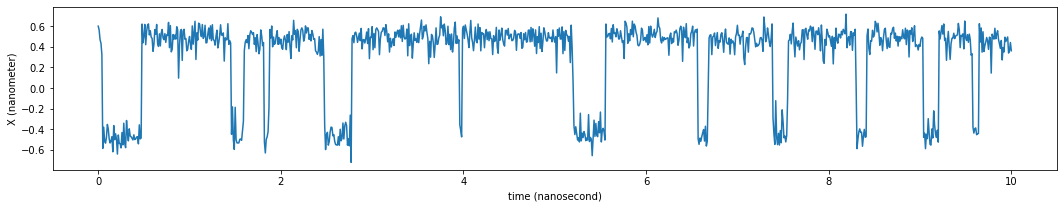

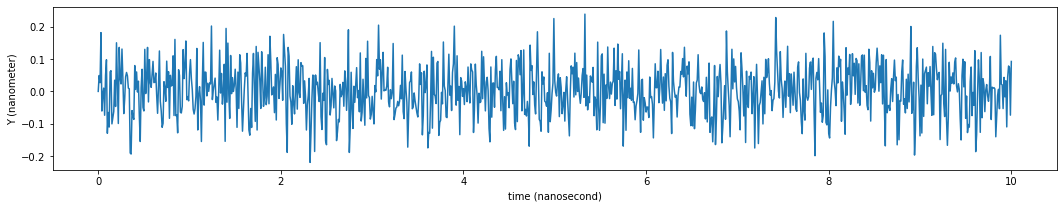

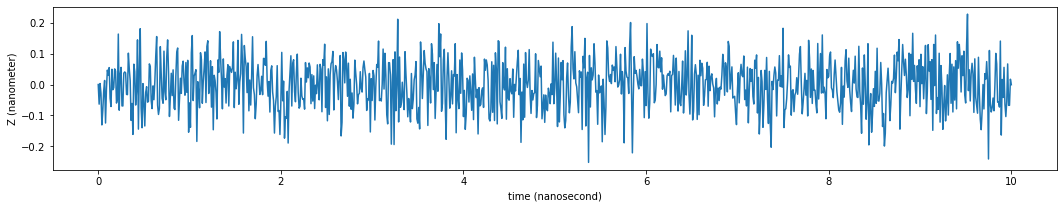

In [48]:
for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(reporter['time'].in_units_of(unit.nanoseconds), reporter['coordinates'][:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, reporter['coordinates'].unit))
    plt.xlabel('time ({})'.format(unit.nanoseconds))
    plt.show()

Ya observamos transiciones entre los dos pozos en el eje $X$. Para concluir veamos el comportamiento de las energías:

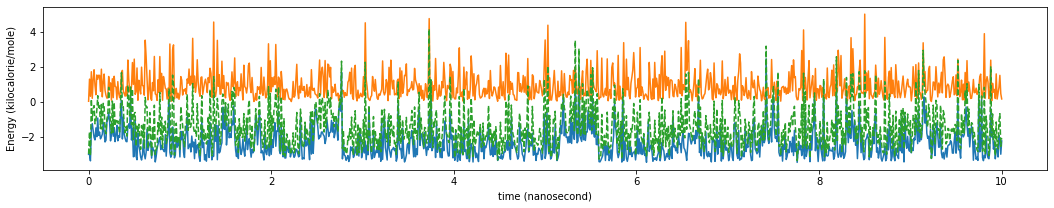

In [49]:
total_energies = reporter['potential_energy']+reporter['kinetic_energy']
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), reporter['potential_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), reporter['kinetic_energy'].in_units_of(unit.kilocalories_per_mole))
plt.plot(reporter['time'].in_units_of(unit.nanoseconds), total_energies.in_units_of(unit.kilocalories_per_mole), '--')
plt.ylabel('Energy ({})'.format(unit.kilocalories_per_mole))
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.show()